In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load and format

In [2]:
# adata = sc.read_h5ad('/stanley/WangLab/morgan/samples/PengIntestines/06.cell_typing/ileum/ileum_final_annos_230222.h5ad')
adata = sc.read_h5ad('/stanley/WangLab/kamal/data/technologies/starmap/ileum/adata_depth_processed2.h5ad')

In [3]:
# Get raw data
adata.X = adata.layers['raw']

# Spatially arange
coords = adata.obs[['column', 'row']].values
# is_gf = adata.obs['sample'] == 'gf'
is_gf = adata.obs['sample'] == 'GF_Ileum'

# Trim fat
del adata.obs
del adata.obsp
del adata.obsm
del adata.var
del adata.varm
del adata.uns
del adata.layers

# Attach spatial info
adata.obsm['spatial'] = coords

# Isolate control sample
adata = adata[~is_gf]

In [4]:
adata

View of AnnData object with n_obs × n_vars = 89925 × 852
    obsm: 'spatial'

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


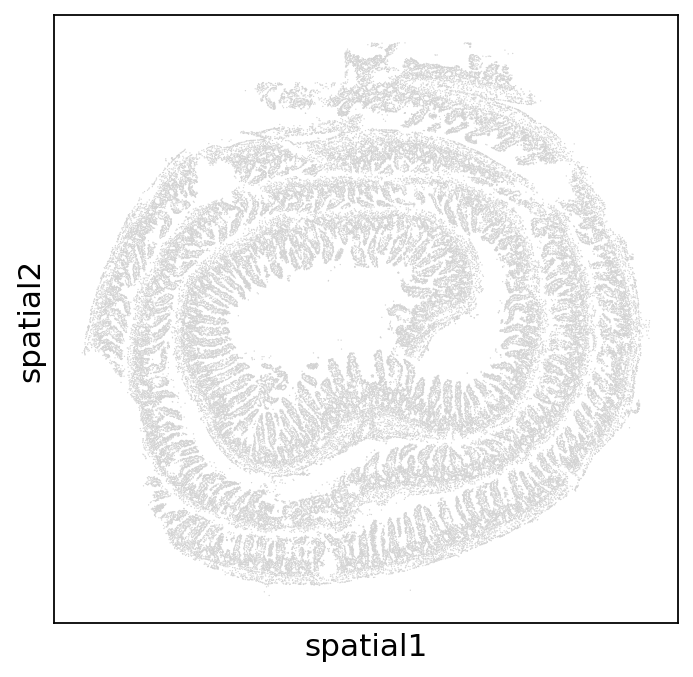

In [5]:
sc.set_figure_params(figsize=(5,5))
sc.pl.embedding(adata, basis='spatial')

In [6]:
# Normalize
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
# Clip
max_mag = 2
X = adata.X
X[X > max_mag] = max_mag
X[X < -max_mag] = -max_mag

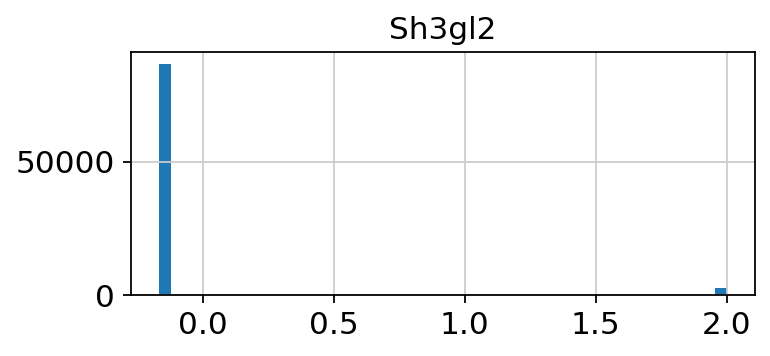

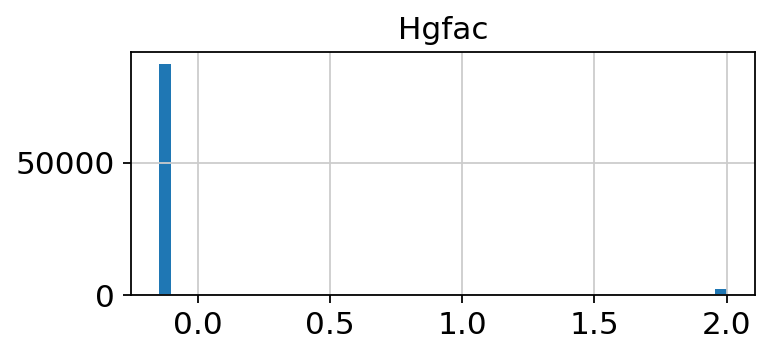

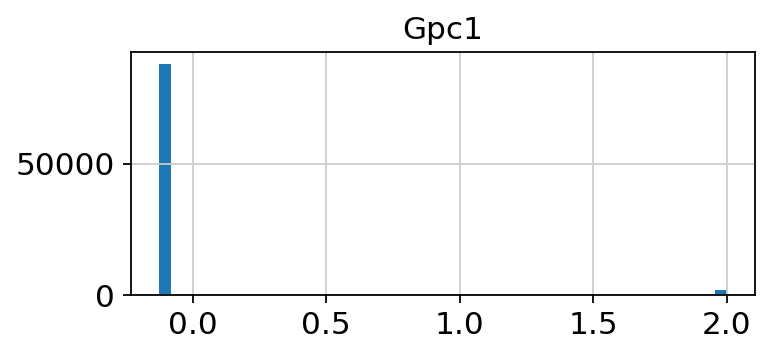

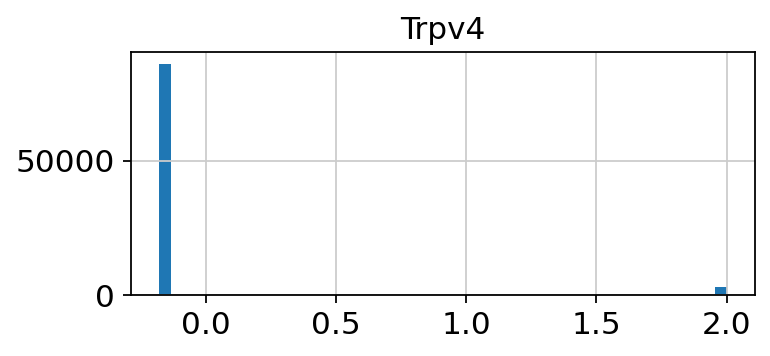

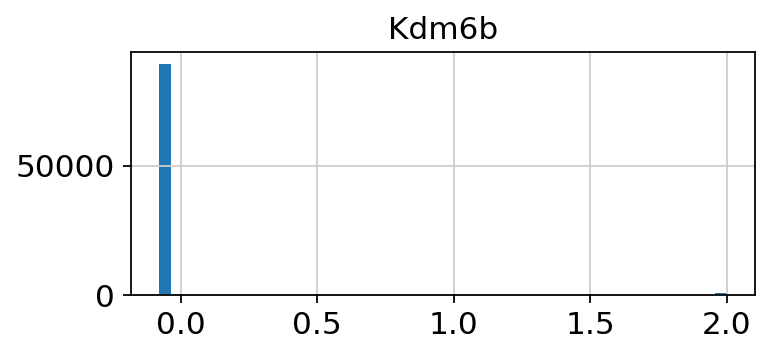

In [8]:
rand_idxs = np.random.choice(np.arange(adata.shape[1]), size=5, replace=False)
for i in rand_idxs:
    plt.figure(figsize=(5,2))
    plt.title(adata.var_names[i])
    plt.hist(adata.X[:,i], bins=50)
    plt.show()

# Cluster regions

In [9]:
def smooth(
    adata,
    k,
    subsample_rate,
    radius,
):

    # Get neighbor info
    if radius:
        nbrs = NearestNeighbors(radius=radius).fit(adata.obsm['spatial'])
        A = nbrs.radius_neighbors_graph()
    else:
        nbrs = NearestNeighbors(n_neighbors=k).fit(adata.obsm['spatial'])
        A = nbrs.kneighbors_graph()
    adata.obsp['spatial_connectivities'] = A.copy()

    # Subsample
    if subsample_rate:
        adata.obsp['spatial_connectivities_subsampled'] = A.copy()
        for i in range(len(adata)):
            nbr_idxs = adata.obsp['spatial_connectivities'][i].nonzero()[1]
            idxs_to_drop = np.random.choice(
                nbr_idxs,
                size=int(len(nbr_idxs)*(1-subsample_rate)),
                replace=False,
            )
            for j in idxs_to_drop:
                adata.obsp['spatial_connectivities_subsampled'][i,j] = 0
        adata.obsp['spatial_connectivities_subsampled'].eliminate_zeros()
    else:
        adata.obsp['spatial_connectivities_subsampled'] = np.eye(adata.shape[0])

    # Smooth
    adata.obsm['X_smoothed'] = adata.obsp['spatial_connectivities_subsampled'] @ adata.X

In [ ]:
# Smooth
# k = 50
k = 100
subsample_rate = 1
radius = None

smooth(adata, k, subsample_rate, radius)

In [12]:
# PCA
n_pcs = 50
pca = PCA(n_components=n_pcs, random_state=2)
X_pca = pca.fit_transform(adata.obsm['X_smoothed'])

In [13]:
# K-means
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
kmeans.fit(X_pca)
adata.obs['region_true'] = kmeans.labels_.astype(str)

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


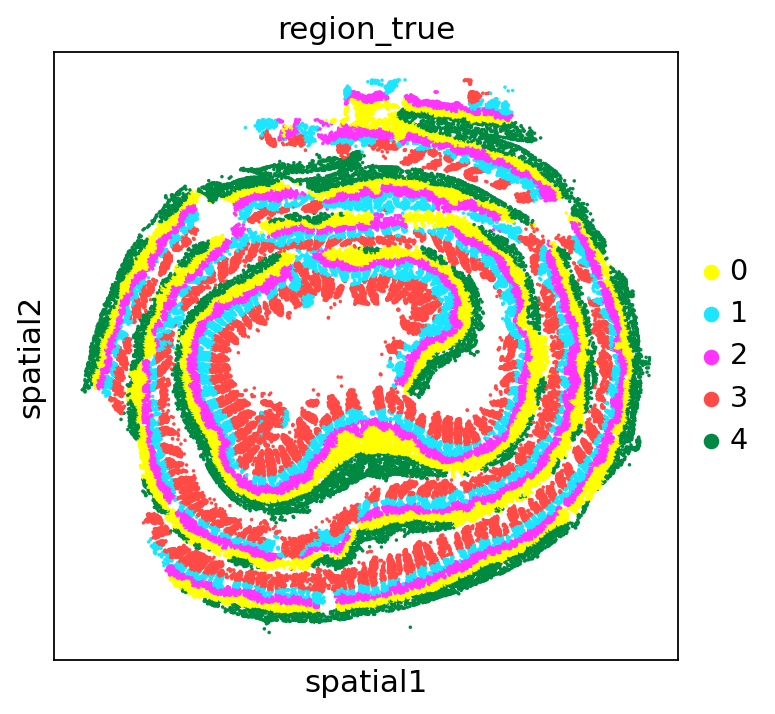

In [14]:
sc.pl.embedding(adata, basis='spatial', color='region_true', s=10, palette=sc.pl.palettes.default_102)

In [15]:
# # Use small chunk for test
# x, y = adata.obsm['spatial'].min(axis=0)
# width, height = adata.obsm['spatial'].ptp(axis=0)

# min_x = x
# max_x = x + width / 3
# min_y = y
# max_y = y + height / 3

# adata = adata[adata.obsm['spatial'][:,0]>min_x]
# adata = adata[adata.obsm['spatial'][:,0]<max_x]
# adata = adata[adata.obsm['spatial'][:,1]>min_y]
# adata = adata[adata.obsm['spatial'][:,1]<max_y].copy()

In [16]:
# sc.pl.embedding(adata, basis='spatial', color='region_true', s=30, palette=sc.pl.palettes.default_102)

## Test scanpy-based neighbors

In [20]:
adata

AnnData object with n_obs × n_vars = 89925 × 852
    obs: 'region_true'
    var: 'mean', 'std'
    uns: 'log1p', 'region_true_colors'
    obsm: 'spatial', 'X_smoothed'
    obsp: 'spatial_connectivities', 'spatial_connectivities_subsampled'

In [21]:
# Find latent neighbors
sc.pp.neighbors(adata, use_rep='X_smoothed', key_added='smoothed')

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/umap/distances.py:

In [22]:
# Leiden clustering
sc.tl.leiden(adata, resolution=0.2, neighbors_key='smoothed')

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


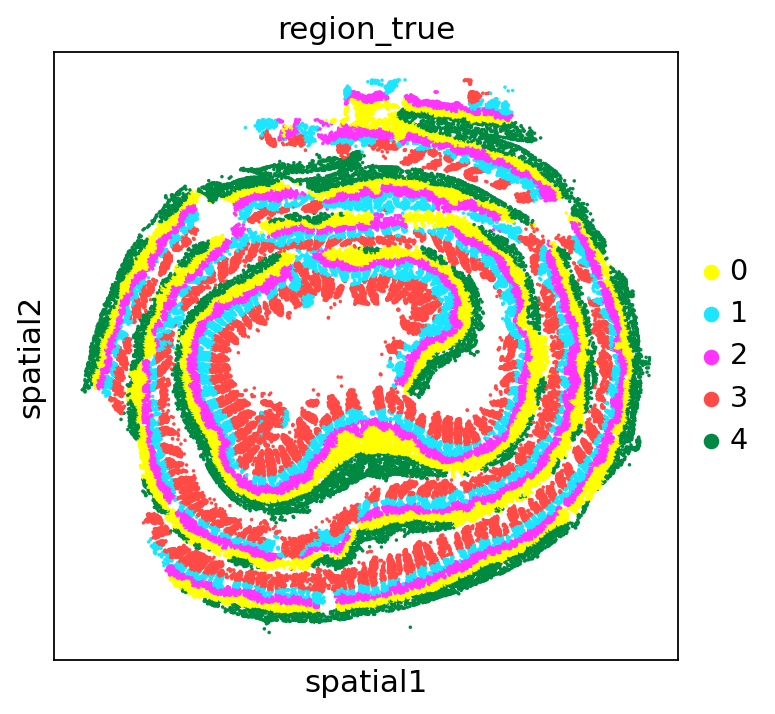

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


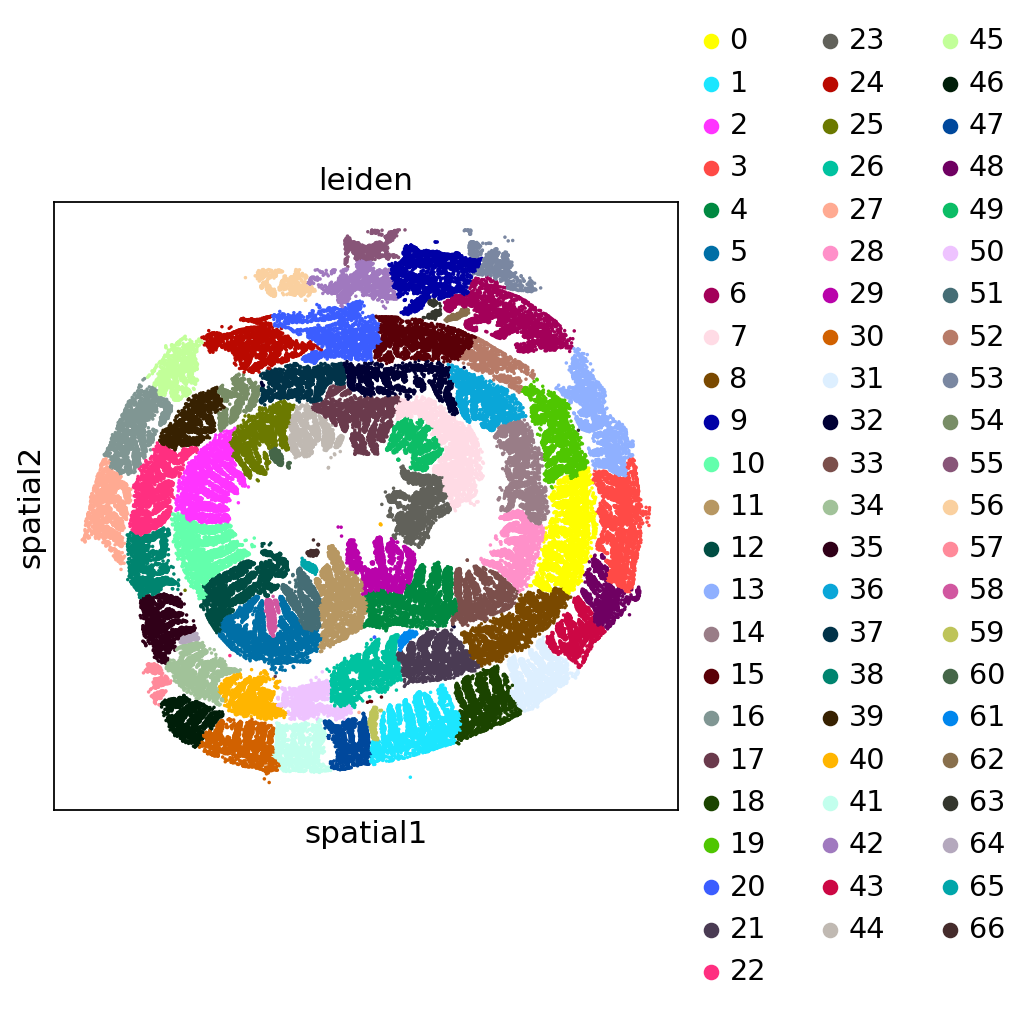

In [23]:
sc.pl.embedding(adata, basis='spatial', color='region_true', s=10, palette=sc.pl.palettes.default_102)
sc.pl.embedding(adata, basis='spatial', color='leiden', s=10, palette=sc.pl.palettes.default_102)

In [10]:
# Smooth
# k = 50
k = 100
subsample_rate = 0.2
radius = None

smooth(adata, k, subsample_rate, radius)

In [11]:
# PCA
n_pcs = 50
pca = PCA(n_components=n_pcs, random_state=2)
X_pca = pca.fit_transform(adata.obsm['X_smoothed'])

In [12]:
# Find latent neighbors
sc.pp.neighbors(adata, use_rep='X_smoothed', key_added='smoothed')

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/umap/distances.py:

In [13]:
# Leiden clustering
sc.tl.leiden(adata, resolution=0.2, neighbors_key='smoothed')

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


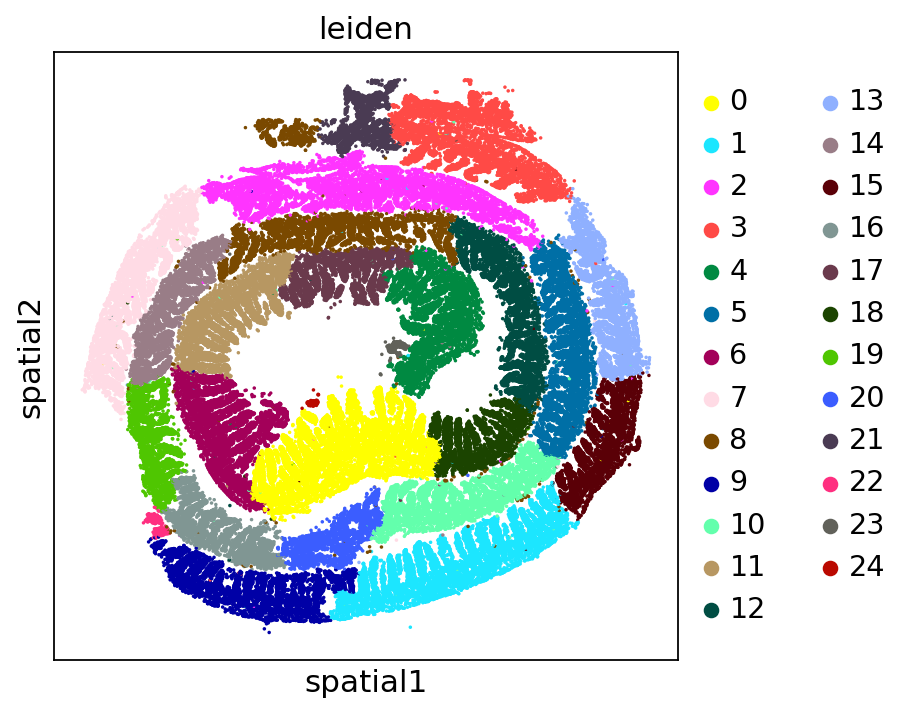

In [15]:
# sc.pl.embedding(adata, basis='spatial', color='region_true', s=10, palette=sc.pl.palettes.default_102)
sc.pl.embedding(adata, basis='spatial', color='leiden', s=10, palette=sc.pl.palettes.default_102)

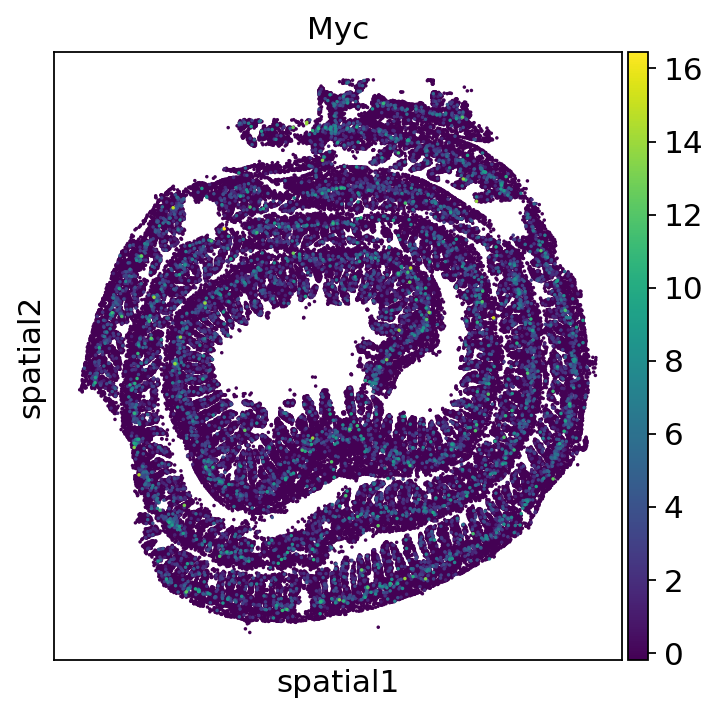

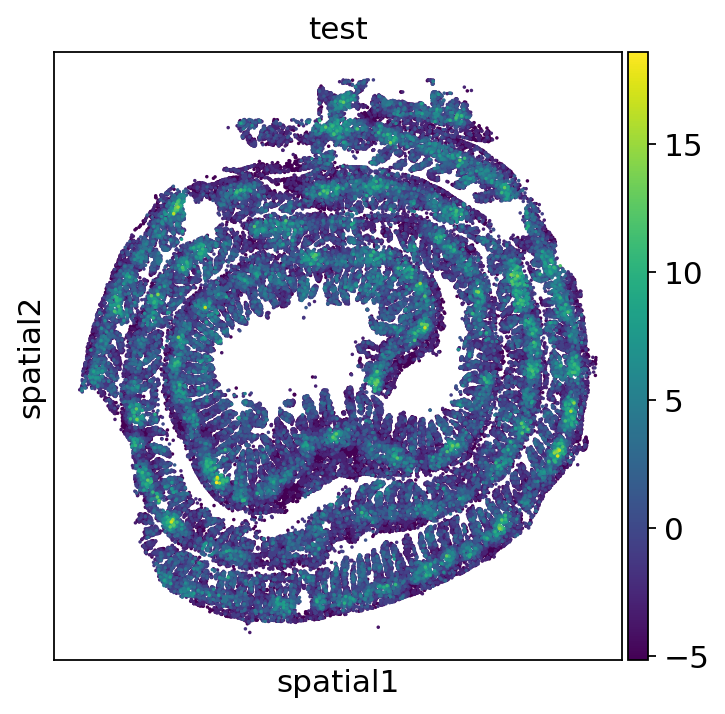

In [22]:
sc.pl.embedding(adata, basis='spatial', color='Myc', s=10)
adata.obs['test'] = adata.obsm['X_smoothed'][:,adata.var_names.get_loc('Myc')]
sc.pl.embedding(adata, basis='spatial', color='test', s=10)

# Write data

In [17]:
adata.write('/stanley/WangLab/kamal/data/projects/spin/reviews/gut/adata.h5ad')

# Solve for optimal radius

## Approximation

In [9]:
adata.obsm['spatial'].ptp(axis=0) / 2

array([13881.5, 12923. ])

Problem statement:
- 5000 cells are randomly distributed within an approximate sphere of radius $\approx$ 13500.
- What is the radius of an inscribed circle that would, on average, contain 50 cells?

Solution:
- Find a fraction of the area that yields the desired fraction of cells, i.e. $\frac{50}{n_{cells}}$
$$\frac{\pi r^2}{\pi(13500)^2} = \frac{50}{n_{cells}}$$
$$\Rightarrow r^2 = \frac{(13500)^2(50)}{n_{cells}}$$
$$\Rightarrow r = \sqrt{\frac{(13500)^2(50)}{n_{cells}}}$$

Hm but wait, I should use 51 since each cell is not considered its own neighbor.

In [10]:
n_cells = len(adata)

In [18]:
radius = np.sqrt((13500**2 * 75)/n_cells)
print(radius)

389.87391302408776


In [19]:
# radius = 260
nbrs = NearestNeighbors(radius=radius).fit(adata.obsm['spatial'])
A = nbrs.radius_neighbors_graph()

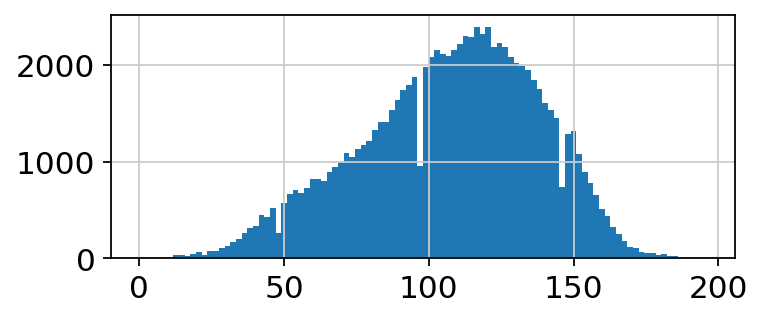

In [20]:
plt.figure(figsize=(5,2))
plt.hist(np.array(A.sum(axis=1)).flatten(), bins=100)
plt.show()

In [21]:
np.array(A.sum(axis=1)).flatten().mean()

107.23276063386155

Using $r=400$

Switched to 100 cells after using a radius of 550 on accident and seeing that it yielded really nice results, **for both kmeans and subsampling+leiden**